# Определение возраста покупателей

По имеющимся данным (набор фотографий людей с указанием возраста) необходимо построить модель, которая по фотографии определит приблизительный возраст человека. За главную метрику качества возьмём функцию потерь MAE.

Перед построением модели рассмотрим данные и проведём их исследовательский анализ данных.

## 1 Исследовательский анализ данных

In [1]:
import pandas as pd
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Прочитаем файл и посмотрим на размер выборки.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
print(labels.shape)

(7591, 2)


In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Имеем выборку из 7591 элементов, с данными всё в порядке, в них нет пустых значений. Выгрузим фото при помощи команды из Keras.

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Построим два графика для выявления распределения возраста в выборке: гистограмму и ящик с усами.

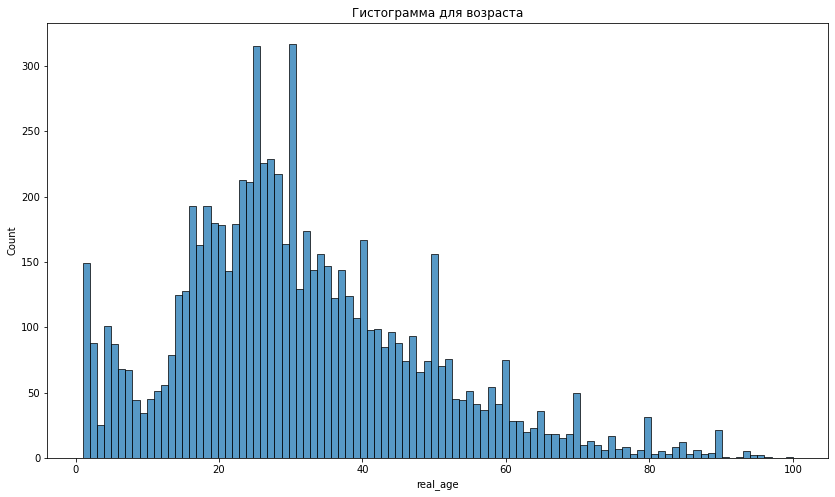

In [6]:
plt.figure(figsize = (14, 8)) 
plt.title('Гистограмма для возраста')
sns.histplot(data = labels['real_age'], bins = 100);

Медианное значение равно 31.20115926755368 
Среднее значение равно 29.0


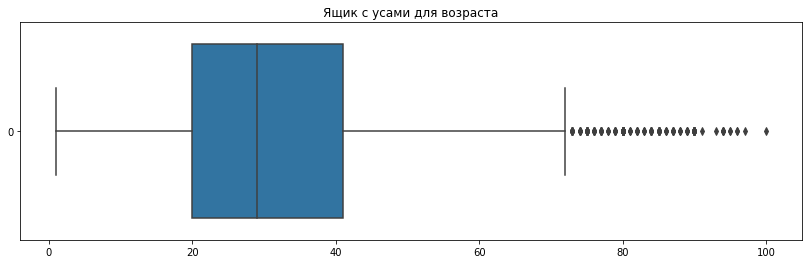

In [7]:
plt.figure(figsize = (14, 4)) 
plt.title('Ящик с усами для возраста')
sns.boxplot(data = labels['real_age'], orient = 'h');
median = np.mean(labels['real_age'])
mean = np.median(labels['real_age'])
print('Медианное значение равно', median, '\nСреднее значение равно', mean)

Видим, что большинство значений лежит в пределах между 15 и 40 годами.

In [8]:
features, target = next(train_gen_flow)
print(features.shape)

(32, 224, 224, 3)


Напечатаем на экран 12 фотографий, чтобы посмотреть, что они собой представляют

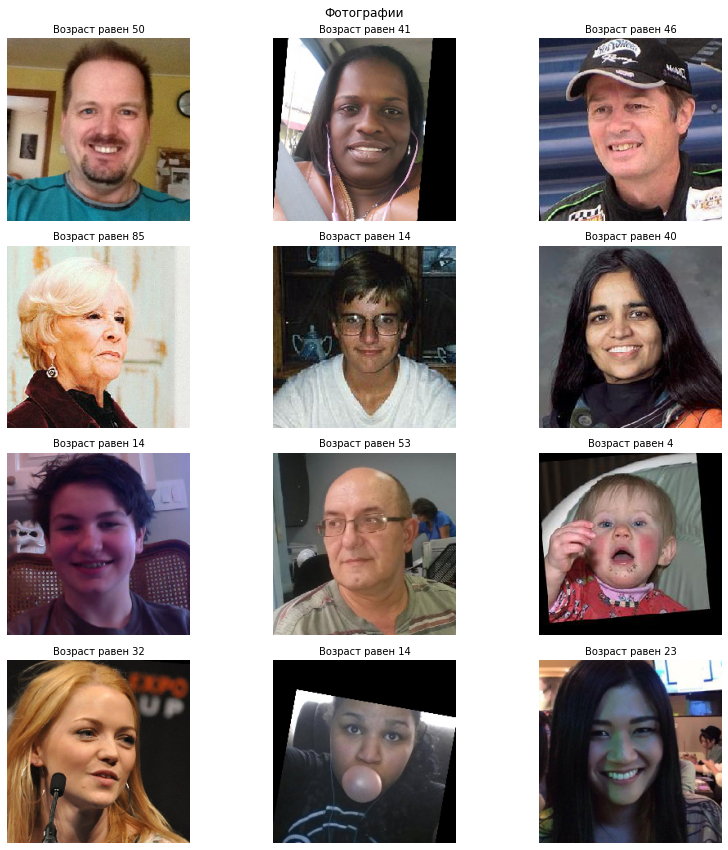

In [9]:
fig = plt.figure(figsize = (12, 12))
for i in range(12):
    plt.suptitle('Фотографии')
    fig.add_subplot(4, 3, i+1)
    plt.title(f'Возраст равен {target[i]}', fontsize = 10)
    plt.imshow(features[i])
    plt.axis('off')
    plt.grid(False)
plt.tight_layout()

**Вывод**

* В данных замечено неравномерное распределение возрастов. Большинство людей на фотографиях имеют возраст от 15 до 40 лет.
* К некоторым фотографиям применена аугментация.
* В наборе присутствуют черно-белые и цветные фото.

## 2 Обучение модели

Ниже представлен код обучаемой модели.

```python

import pandas as pd
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

 
def load_train(path):
    data = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale = 1/255.,
                                       horizontal_flip = True,
                                       width_shift_range = 0.2,
                                       height_shift_range = 0.2,
                                       validation_split = 0.2)
                                       
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe = data,
                                                      directory = path + '/final_files',    
                                                      x_col = 'file_name',
                                                      y_col = 'real_age',
                                                      target_size = (224, 224),
                                                      batch_size = 32,
                                                      class_mode = 'raw',
                                                      subset = 'training',  
                                                      seed = 12345)
    return train_datagen_flow


def load_test(path):
    data = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale = 1/255.,
                                      validation_split = 0.2)
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe = data,
                                                         directory = path+'/final_files',
                                                         x_col = 'file_name',
                                                         y_col = 'real_age',
                                                         target_size = (224, 224),
                                                         batch_size = 32,
                                                         class_mode = 'raw',
                                                         subset = 'validation',     
                                                         seed = 12345)
                                                         
    return test_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape = input_shape, 
                        weights = 'imagenet',
                        include_top = False)
    optimizer = Adam(lr = 0.0001)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units = 1, activation = 'relu')) 
    model.compile(optimizer=optimizer, loss = 'mean_squared_error',
                  metrics = ['mae'])

    return model


def train_model(model, train_data, test_data, batch_size = None, epochs = 10,
               steps_per_epoch = None, validation_steps = None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
        
    if validation_steps is None:
        validation_steps = len(test_data)
        
    model.fit(train_data,
              validation_data = test_data,
              batch_size = batch_size, 
              epochs = epochs,
              steps_per_epoch = steps_per_epoch,
              validation_steps = validation_steps,
              verbose = 2,
              shuffle = True)
              
    return model

```

Ниже представлен вывод результата обученной модели.

```

Train for 190 steps, validate for 48 steps
Epoch 1/10
2023-03-24 13:40:47.775383: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-03-24 13:40:49.859914: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
190/190 - 124s - loss: 301.7103 - mae: 12.2847 - val_loss: 490.9043 - val_mae: 16.9551
Epoch 2/10
190/190 - 93s - loss: 92.0022 - mae: 7.2480 - val_loss: 538.8466 - val_mae: 18.0379
Epoch 3/10
190/190 - 92s - loss: 73.3722 - mae: 6.4737 - val_loss: 388.3869 - val_mae: 14.8319
Epoch 4/10
190/190 - 93s - loss: 59.3897 - mae: 5.8761 - val_loss: 105.1015 - val_mae: 7.6540
Epoch 5/10
190/190 - 92s - loss: 50.3822 - mae: 5.4800 - val_loss: 75.3097 - val_mae: 6.3969
Epoch 6/10
190/190 - 93s - loss: 44.3302 - mae: 5.1350 - val_loss: 83.1057 - val_mae: 6.9509
Epoch 7/10
190/190 - 92s - loss: 39.1097 - mae: 4.8047 - val_loss: 91.1329 - val_mae: 6.8892
Epoch 8/10
190/190 - 92s - loss: 34.4320 - mae: 4.5097 - val_loss: 73.7674 - val_mae: 6.2604
Epoch 9/10
190/190 - 93s - loss: 30.0466 - mae: 4.1967 - val_loss: 69.5160 - val_mae: 6.0267
Epoch 10/10
190/190 - 92s - loss: 25.3076 - mae: 3.8950 - val_loss: 62.1871 - val_mae: 5.7932
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
48/48 - 7s - loss: 62.1871 - mae: 5.7932
Test MAE: 5.7932

```

Метрика MAE равна 5.8, то есть ниже 8, что и требовалось от бизнес-задачи.

## 3 Анализ обученной модели

Обученная модель имела структуру ResNet50, алгоритм Adam с частотой обучения, равной 0.0001.

Была проведена аугментация изображений в виде горизонтального/вертикального отражений и сдвигов по длине/ширине.
Веса для изображений были взяты из базы данных ImageNet.

## Вывод

* Был проведён исследовательский анализ данных, представляющих из себя изображение.
* Была обучена модель со структурой ResNet50 и алгоритмом Adam.
* Метрика MAE обученной модели оказалась не больше 8, что и требовалось от поставленной задачи.